<a href="https://colab.research.google.com/github/chinefed/convolutional-set-transformer/blob/main/cst15_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Transfer Learning with CST-15 on colorectal histology images

✉️ If you have any questions or concerns, please feel free to contact me at federico.chinello@studbocconi.it.

✅ As a first step, we install the **cstmodels** package, which we developed to provide reusable CST layers and pre-trained models.

In [ ]:
!pip install cstmodels

We import some key packages.

In [2]:
import os
# Keras backend must be set to Tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'
import random

import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load and prepare the data

We load the Colorectal Histology dataset from Tensorflow and split it into train, validation, and test. We adapt CST-15 to the new dataset using the **Set-free Transfer Learning Scheme**, i.e., we do not use sets in the TL phase but only isolated images (each image is be treated as a singleton set). This matches the standard CNN training setup. Nevertheless, we will show that the model retains the ability to perform inference on arbitrarily large image sets, with accuracy improving as the set size grows. This is because the CST-15 backbone has already learned to exploit relationships between images within a set during ImageNet pre-training and does not need to re-learn this capability during Transfer Learning.  

*The Colorectal Histology dataset is designed for the classification of tissue textures in colorectal cancer histology. It contains RGB microscopy images of size 150 × 150 × 3, with each sample belonging to one of 8 distinct tissue classes.*

In [ ]:
import tensorflow_datasets as tfds

# We load the dataset and split it into train, validation, and test (70%, 15%, 15%)
splits = ['train[:70%]', 'train[70%:85%]', 'train[85%:]']
(train_ds, val_ds, test_ds) = tfds.load(
    'colorectal_histology',
    split=splits,
    as_supervised=True
)

def add_set_dim(image, label):
    # Add set dimension to each image to match
    # the input shape expected by CST-15
    # (We treat each image as a set of size 1)
    image = tf.expand_dims(image, axis=0)   # (1, H, W, C)
    return image, label

# Set-free TL -> we treat each iamge as a set of size 1
train_ds = train_ds.map(add_set_dim).shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(add_set_dim).batch(64).prefetch(tf.data.AUTOTUNE)

## Load CST-15 pre-trained on ImageNet

We begin by loading the CST-15 model and replacing its final layer (the 1000-class ImageNet head) with a new classification layer specific to the 8 Colorectal Histology categories:

In [4]:
from keras import layers
from cstmodels import CST15

# Load CST-15
base_model = CST15(pretrained=True)

# Remove the ImageNet classification layer
base_model = keras.Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)
# Set the CST-15 backbone to non-trainable
base_model.trainable = False

# Attach the new classification layer
output = layers.Dense(units=8, activation='softmax')(base_model.output)
tl_model = keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
tl_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, weight_decay=5e-4),
    metrics=['accuracy']
)

# Print the model summary
tl_model.summary()

113460260/113460260 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 222 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None, 3)    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_input       │ [(None, None,     │          0 │ input_layer[0][0] │
│ (SmartReshape2D)    │ None, 3), ()]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, None,      │          0 │ reshape_input[0]… │
│ (TrueDivide)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ true_divide[0][0] │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, None,      │          0 │ add[0][0]         │
│ (TrueDivide)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │      1,792 │ true_divide_1[0]… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, None,      │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, None,      │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, None,      │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_setconv1     │ (None, None,      │    558,336 │ block2_pool[0][0… │
│ (SetConv2D)         │ None, 256)        │            │ reshape_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_setconv2     │ (None, None,      │    853,248 │ block3_setconv1[… │
│ (SetConv2D)         │ None, 256)        │            │ reshape_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, None,      │          0 │ block3_setconv2[… │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_setconv1     │ (None, None,      │  2,230,784 │ block3_pool[0][0… │
│ (SetConv2D)         │ None, 512)        │            │ reshape_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_setconv2     │ (None, None,      │  3,410,432 │ block4_setconv1[… │
│ (SetConv2D)         │ None, 512)        │            │ reshape_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_setconv3     │ (None, None,      │  3,410,432 │ block4_setconv2[

 Total params: 27,779,656 (105.97 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 27,775,552 (105.96 MB)

## Training

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 531ms/step - accuracy: 0.3206 - loss: 2.7986 - val_accuracy: 0.6600 - val_loss: 0.9993
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6973 - loss: 0.8394 - val_accuracy: 0.7400 - val_loss: 0.7138
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7757 - loss: 0.6126 - val_accuracy: 0.7853 - val_loss: 0.6137
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8135 - loss: 0.5172 - val_accuracy: 0.8027 - val_loss: 0.5879
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8421 - loss: 0.4487 - val_accuracy: 0.8133 - val_loss: 0.5543
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8543 - loss: 0.4176 - val_accuracy: 0.8347 - val_loss: 0.5268
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8515 - loss: 0.4034 - val_accuracy: 0.8267 - val_loss: 0.5086
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8619 - loss: 0.3676 - val_accuracy: 

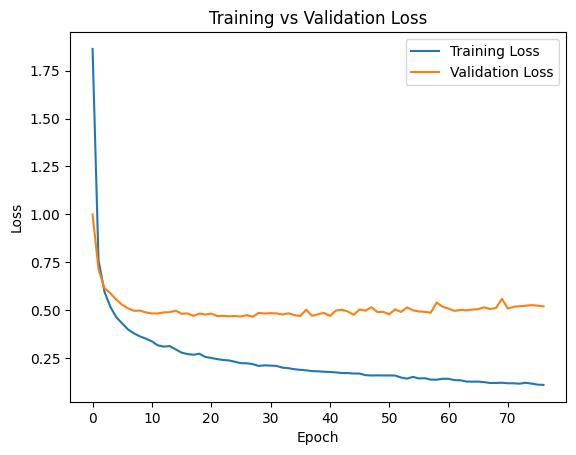

In [5]:
# Set the early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='auto'
    )
]

# Fit the model
history = tl_model.fit(
    train_ds,
    epochs=500,
    validation_data=val_ds,
    callbacks=callbacks
).history

# Plot training & validation loss
plt.plot(history['loss'], label='Training Loss', color='tab:blue')
plt.plot(history['val_loss'], label='Validation Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

## Evaluation on the test set

After training on individual images (each image treated as a set of unit size), we test for Contextualize Image Classification with sets of arbitrary size.

In [6]:
from collections import defaultdict

class CombinatorialGenerator():
    def __init__(self, data, set_size_range, batch_size):
        self.data = data
        self.n_classes = len(self.data)
        self.set_size_range = set_size_range
        self.batch_size = batch_size
        self.on_epoch_end()

    @property
    def n_steps(self):
        return len(self.sets) // self.batch_size

    def generate(self):
        for index in range(self.n_steps):
            batch = self.sets[index*self.batch_size:(index+1)*self.batch_size]

            # Input: (batch_size, set_size, height, widthm channels)
            X = np.array(
                [[np.array(image['image']) for image in image_set] for image_set in batch]
            )
            # Output: (batch_size * set_size,) - we use sparse categorical cross-entropy
            y = np.array(
                [image['label'] for image_set in batch for image in image_set]
            )

            yield X, y

        self.on_epoch_end()

    def on_epoch_end(self):
        # Draw the set size uniformly at random
        set_size = random.randint(*self.set_size_range)

        self.sets = []
        for label in self.data:
            # For every class, randomly create the sets
            random.shuffle(self.data[label])
            self.sets += self.split_list(self.data[label], set_size)
        random.shuffle(self.sets)

    def split_list(self, input_list, k):
        n = len(input_list)
        splitted = [input_list[i:i+k] for i in range(0, n, k) if i+k <= n]

        return splitted


def to_numpy(ds):
  '''
  Convert TF dataset to numpy.
  '''
  X, y = [], []
  for images, labels in ds:
      X.append(images.numpy())
      y.append(labels.numpy())

  X = np.concatenate(X, axis=0)
  y = np.concatenate(y, axis=0)

  return X, y


def reshape_data(X, y):
  '''
    Reorganize the data to match the format required by 'CombinatorialGenerator'.
  '''
  split = defaultdict(list)
  for i, label in enumerate(y.flatten()):
    split[label] += [{'image': X[i], 'label': label}]
  return split


# Convert test dataset to numpy
test_ds = test_ds.batch(8)
X, y = to_numpy(test_ds)
# Reorganize
test_data = reshape_data(X, y)

Let's visualize a set of 10 images from the same class:

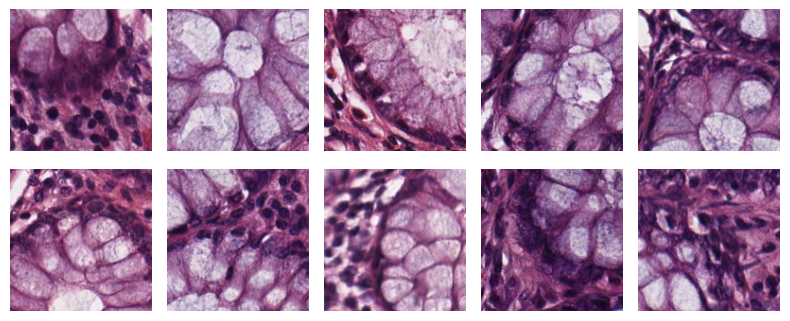

In [7]:
from collections import defaultdict

test_gen = CombinatorialGenerator(data=test_data, set_size_range=(10, 10), batch_size=1)
batch_x, _ = next(iter(test_gen.generate()))
image_set = batch_x[0]

n_cols = 5 # Number of images per row
n_rows = int(np.ceil(len(image_set) / n_cols))

plt.figure(figsize=(8, 1.75 * n_rows))

for i, img in enumerate(image_set):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

We evaluate the trained model’s Contextualized Image Classification accuracy on input sets ranging in size from 1 to 10

750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8723 - loss: 0.4066


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9512 - loss: 0.1636
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9568 - loss: 0.1333
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9651 - loss: 0.0938
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9595 - loss: 0.1128
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9721 - loss: 0.0950
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9768 - loss: 0.0821
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9821 - loss: 0.0731
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9687 - loss: 0.0818
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9833 - loss: 0.0700
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9851 - loss: 0.0536
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9455 - loss: 0.1267
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9803 - loss: 0.0880
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9859 - loss: 0.0667
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 16

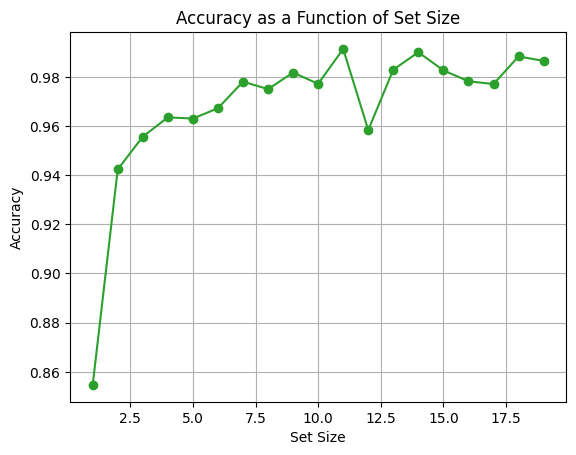

In [8]:
output_signature = (
    tf.TensorSpec(shape=(None, None, 150, 150, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

accuracies = []
for i in range(1, 20):
    test_gen = CombinatorialGenerator(
        test_data,
        set_size_range=(i, i),
        batch_size=1,
    )

    test_ds = tf.data.Dataset.from_generator(
      test_gen.generate,
      output_signature=output_signature
    )

    _, accuracy = tl_model.evaluate(test_ds)
    accuracies.append(accuracy)

# Plot accuracies vs set size
plt.plot(range(1, 20), accuracies, marker='o', color='tab:green')
plt.xlabel('Set Size')
plt.ylabel('Accuracy')
plt.title('Accuracy as a Function of Set Size')
plt.grid(True)
plt.show()